# ADHD Dectection
[INTRODUCTION OF THE PROBLEM HERE]

## Dataset:
[ADD AND COMMENT ABOUT DATASETS HERE]

## Task:
[ADD TASK HERE]

## Integrants:
Name, Matricola, Email

- Jan Elfes, 2040496, jan.elfes@studenti.unipd.it

- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it


## Dependencies

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
import pandas as pd
from config_local import helpers

from sklearn.linear_model import Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import lasso_path, enet_path

hp = helpers()

In [2]:
_data_path = hp.get_data_path()
print(_data_path)

data/


## Baseline

Before working with the FMRI data we will fit a logistic regression classifier on the phenotypic tabular data to come up with a baseline. We expect that any experiment using the FMRI data outperforms the following result.

In [3]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv")
phenotypic_df.head()

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Full4 IQ,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2,Fold,Partition
0,1000804,5,1.0,7.29,0.83,0,NaN,2,40,41,...,109,1,1.0,0.0,NaN,NaN,1.0,NaN,4.0,train
1,1023964,5,1.0,8.29,0.57,3,NaN,2,60,56,...,123,-999,1.0,0.0,NaN,NaN,1.0,1.0,3.0,train
2,1057962,5,1.0,8.78,-999.00,1,NaN,2,77,81,...,129,1,1.0,NaN,NaN,NaN,1.0,0.0,1.0,train
3,1099481,5,0.0,8.04,0.50,1,NaN,2,86,82,...,116,1,1.0,0.0,NaN,NaN,1.0,1.0,2.0,train
4,1127915,5,0.0,12.44,0.21,0,NaN,2,42,43,...,124,1,1.0,1.0,NaN,NaN,1.0,1.0,4.0,train


We are going to use `"Gender", "ADHD Index", "Age", "Handedness", "Inattentive", "Hyper/Impulsive", "Verbal IQ","Performance IQ", "Full4 IQ", "Med Status", "QC_Rest_1", "QC_Rest_2", "QC_Anatomical_1", "QC_Anatomical_2"` as predictors and use the token `-999` to fill and recognize NaN values.

In [4]:
features = ["Gender", "ADHD Index", "Age", "Handedness", 
            "Inattentive", "Hyper/Impulsive", "Verbal IQ",
           "Performance IQ", "Full4 IQ", "Med Status",
            "QC_Rest_1", "QC_Rest_2", "QC_Anatomical_1", 
            "QC_Anatomical_2"]

phenotypic_df = phenotypic_df[features + ["DX", "Fold", "Partition"]].fillna(-999)
# turn the problem into a binary classification task
phenotypic_df["DX"] = np.where(phenotypic_df["DX"] == 0, 0, 1)

In [5]:
train_df = phenotypic_df[phenotypic_df["Partition"] == "train"]
test_df = phenotypic_df[phenotypic_df["Partition"] == "test"]
scores = []

for fold in range(1, 6):
    X_train = train_df[train_df["Fold"] != fold][features]
    y_train = train_df[train_df["Fold"] != fold]["DX"]
    
    X_val = train_df[train_df["Fold"] == fold][features]
    y_val = train_df[train_df["Fold"] == fold]["DX"]
    
    clf = LogisticRegression(max_iter=7000,
                         solver="saga",
                         penalty=None,
                         random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    score = f1_score(y_val, y_pred, average="weighted")
    scores.append(score)
    print(f"Fold {fold} -- f1-Score (val): {score}")
print(f"\nAverage f1-Score (val): {np.mean(scores)}")

Fold 1 -- f1-Score (val): 0.7407511407511407
Fold 2 -- f1-Score (val): 0.8815359477124184
Fold 3 -- f1-Score (val): 0.7546218487394958
Fold 4 -- f1-Score (val): 0.7932263814616756
Fold 5 -- f1-Score (val): 0.6976264189886481

Average f1-Score (val): 0.7735523475306756


# Lasso

As first model we will use a simple Lasso regression for the fMRI data. 

In [6]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv").fillna(-999)
dic = {}

for i, row in phenotypic_df.iterrows():
    
    id = str(row['ScanDir ID']).zfill(7)
    fold = int(row['Fold'])
    part = row['Partition']

    if fold != -999:
        file = _data_path + f"{part}/fold{fold}/wmean_mrda{id}_session_1_rest_1.nii.gz"
        img = nib.load(file)
        data = img.get_fdata()
        y = row['DX']
        y_bin = int(y>=1)
        dic[id] = {"img":img, "data":data, "dx":y, "dx_bin":y_bin, "part":part, "fold":fold, "data_reduced":data[10:-10, 10:-10, :-20]}

In [7]:
def train_loader(dic, i, pca=False):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if ((subj["part"]=="train") & (subj["fold"]!=i)):
            X_train.append(subj['data_reduced'].reshape(-1))
            y_train.append(subj['dx_bin'])
                
        if ((subj["part"]=="train") & (subj["fold"]==i)):
            X_val.append(subj['data_reduced'].reshape(-1))
            y_val.append(subj['dx_bin'])
            
    if pca:
        transformer = MiniBatchSparsePCA(n_components=10,
                                         batch_size=3,
                                         random_state=42)
        transformer.fit(X_train)
        X_train = transformer.transform(X_train)
        X_val = transformer.transform(X_val)

    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [8]:
# Create X and y array
for i in range(1, 6):
    X_train, y_train, X_val, y_val = train_loader(dic, i)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(136, 29754) (136,) (35, 29754) (35,)
(137, 29754) (137,) (34, 29754) (34,)
(137, 29754) (137,) (34, 29754) (34,)
(137, 29754) (137,) (34, 29754) (34,)
(137, 29754) (137,) (34, 29754) (34,)


In [9]:
scores = []

for fold in range(1, 6):

    X_train, y_train, X_val, y_val = train_loader(dic, fold)

    clf = Lasso(alpha=0.01,
                random_state=42,
                max_iter=7000).fit(X_train, y_train)
    y_pred = np.round(clf.predict(X_val))
    
    score = f1_score(y_val, y_pred, average="weighted")
    scores.append(score)
    print(f"Fold {fold} -- f1-Score (val): {score}")
print(f"\nAverage f1-Score (val): {np.mean(scores)}")

Fold 1 -- f1-Score (val): 0.6378378378378378
Fold 2 -- f1-Score (val): 0.7346017744499717
Fold 3 -- f1-Score (val): 0.6470588235294118
Fold 4 -- f1-Score (val): 0.5504543280726926
Fold 5 -- f1-Score (val): 0.5243697478991597

Average f1-Score (val): 0.6188645023578146


## Model selection Lasso

In [11]:
f1_scores_mean = []
coefs_lasso_mean = []
X_train, y_train, _, _ = train_loader(dic, 1)
eps=1e-3
lambdas_lasso, _, _ = lasso_path(X_train, y_train, eps=eps, random_state=42) # get nicely distributed lambdas

for lam in lambdas_lasso:
    f1_scores = []
    coefs = []
    for fold in range(1, 6):

        X_train, y_train, X_val, y_val = train_loader(dic, fold)

        clf = Lasso(alpha=lam,
                    random_state=42,
                    max_iter=7000).fit(X_train, y_train)
        y_pred = np.round(clf.predict(X_val))
        
        score = f1_score(y_val, y_pred, average="weighted")

        f1_scores.append(score)
        coefs.append(clf.coef_)

    f1_scores_mean.append(np.mean(f1_scores))
    coefs_lasso_mean.append(np.mean(coefs, axis=0))

    print(f"\n Lambda = {np.round(lam, 8)}  \t\tAverage f1-Score (val): {f1_scores_mean[-1]}\n")

/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-02, tolerance: 7.400e-03
  model = cd_fast.enet_coordinate_descent(
/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.048e-03, tolerance: 7.400e-03
  model = cd_fast.enet_coordinate_descent(
/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.605e-03, tolerance: 7.400e-03
  model = cd_fast.enet_coordinate_descent(



 Lambda = 52.85698476  		Average f1-Score (val): 0.38327482194296847


 Lambda = 49.29460089  		Average f1-Score (val): 0.38327482194296847


 Lambda = 45.97230977  		Average f1-Score (val): 0.38327482194296847


 Lambda = 42.87392996  		Average f1-Score (val): 0.38327482194296847


 Lambda = 39.98437057  		Average f1-Score (val): 0.38327482194296847


 Lambda = 37.28955782  		Average f1-Score (val): 0.38327482194296847


 Lambda = 34.77636643  		Average f1-Score (val): 0.38327482194296847


 Lambda = 32.43255572  		Average f1-Score (val): 0.38327482194296847


 Lambda = 30.24671001  		Average f1-Score (val): 0.38327482194296847


 Lambda = 28.20818299  		Average f1-Score (val): 0.38327482194296847


 Lambda = 26.30704587  		Average f1-Score (val): 0.38327482194296847


 Lambda = 24.53403902  		Average f1-Score (val): 0.38327482194296847


 Lambda = 22.8805269  		Average f1-Score (val): 0.38327482194296847


 Lambda = 21.33845597  		Average f1-Score (val): 0.38327482194296847


 Lambd

Lambda with minimal f1-score: λ = 0.74923
Respective f1-score:	f1 = 0.651


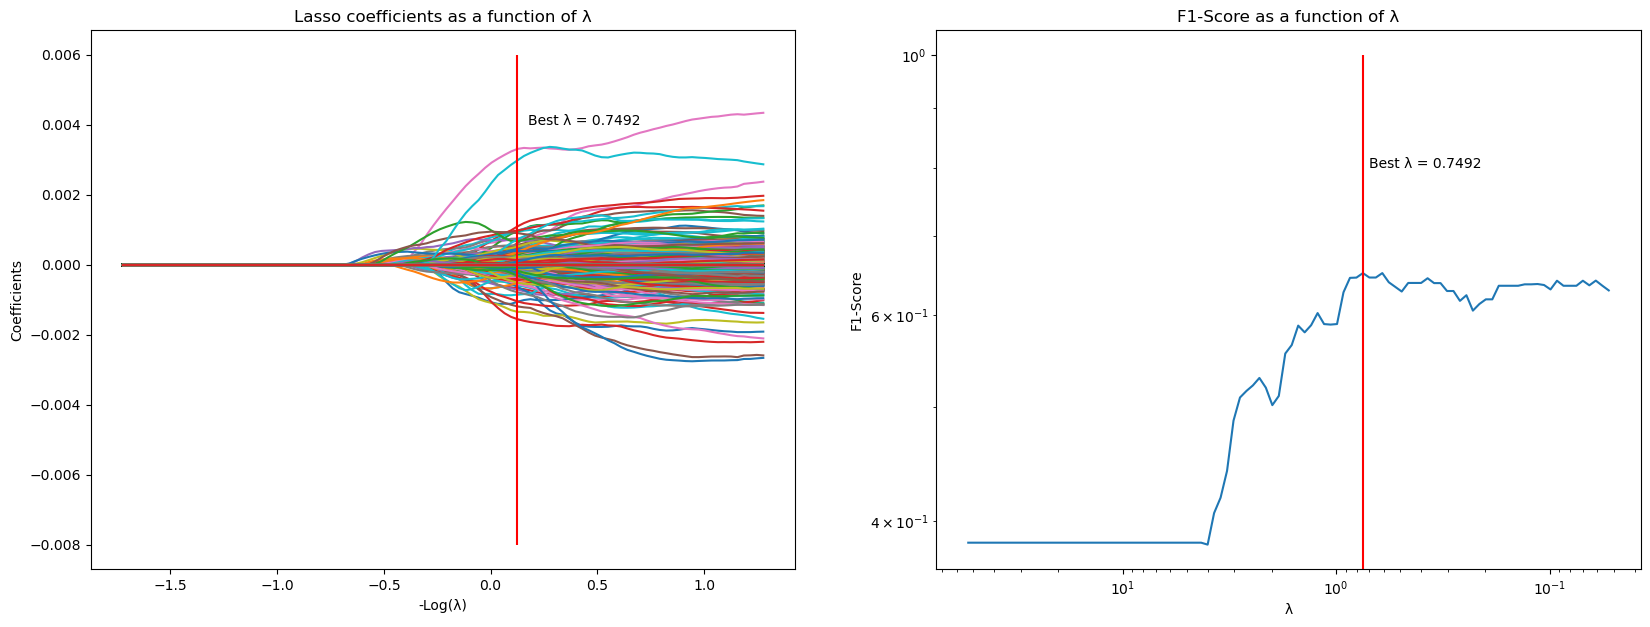

In [22]:
# Display results
best_index = np.argmax(f1_scores_mean)
print(f"Lambda with minimal f1-score: \u03BB = {np.round(lambdas_lasso[best_index], 5)}")
print(f"Respective f1-score:\tf1 = {np.round(f1_scores_mean[best_index], 3)}")

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
neg_log_lambdas_lasso = -np.log10(lambdas_lasso)

ax[0].plot(neg_log_lambdas_lasso, np.array(coefs_lasso_mean))
ax[0].vlines(x=neg_log_lambdas_lasso[best_index], ymin=-0.008, ymax=0.006, color="red")
ax[0].text(neg_log_lambdas_lasso[best_index]+0.05, 0.004, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[0].set_xlabel("-Log(\u03BB)")
ax[0].set_ylabel("Coefficients")
ax[0].set_title('Lasso coefficients as a function of \u03BB')
ax[0].axis("tight")

ax[1].plot(lambdas_lasso, f1_scores_mean)
ax[1].vlines(x=lambdas_lasso[best_index], ymin=0, ymax=1, color="red")
ax[1].text(lambdas_lasso[best_index]-0.05, 0.8, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axis('tight')
ax[1].invert_xaxis()
ax[1].set_xlabel('\u03BB')
ax[1].set_ylabel('F1-Score')
_ = ax[1].set_title('F1-Score as a function of \u03BB')

TODO: need to implement AIC/BIC for model selection. For Lasso in sklearn this seems to be `LassoLarsIC` but did not make it work yet.

## Model Selection Elasticnet

In [27]:
f1_scores_mean = []
coefs_enet_mean = []
#X_train, y_train, _, _ = train_loader(dic, 1)
#lambdas_lasso, _, _ = lasso_path(X_train, y_train, eps=eps, random_state=42) # get nicely distributed lambdas

for lam in lambdas_lasso:
    f1_scores = []
    coefs = []
    for fold in range(1, 6):

        X_train, y_train, X_val, y_val = train_loader(dic, fold)

        clf = ElasticNet(alpha=lam,
                         l1_ratio=0.5,
                         random_state=42,
                         max_iter=7000).fit(X_train, y_train)
        y_pred = np.round(clf.predict(X_val))
        
        score = f1_score(y_val, y_pred, average="weighted")

        f1_scores.append(score)
        coefs.append(clf.coef_)

    f1_scores_mean.append(np.mean(f1_scores))
    coefs_enet_mean.append(np.mean(coefs, axis=0))

    print(f"\n Lambda = {np.round(lam, 8)}  \t\tAverage f1-Score (val): {f1_scores_mean[-1]}\n")


 Lambda = 52.85698476  		Average f1-Score (val): 0.38327482194296847


 Lambda = 49.29460089  		Average f1-Score (val): 0.38327482194296847


 Lambda = 45.97230977  		Average f1-Score (val): 0.38327482194296847


 Lambda = 42.87392996  		Average f1-Score (val): 0.38327482194296847


 Lambda = 39.98437057  		Average f1-Score (val): 0.38327482194296847


 Lambda = 37.28955782  		Average f1-Score (val): 0.38327482194296847


 Lambda = 34.77636643  		Average f1-Score (val): 0.38327482194296847


 Lambda = 32.43255572  		Average f1-Score (val): 0.38327482194296847


 Lambda = 30.24671001  		Average f1-Score (val): 0.38327482194296847


 Lambda = 28.20818299  		Average f1-Score (val): 0.38327482194296847


 Lambda = 26.30704587  		Average f1-Score (val): 0.38327482194296847


 Lambda = 24.53403902  		Average f1-Score (val): 0.38327482194296847


 Lambda = 22.8805269  		Average f1-Score (val): 0.38327482194296847


 Lambda = 21.33845597  		Average f1-Score (val): 0.38327482194296847


 Lambd

Lambda with minimal f1-score: λ = 1.50539
Respective f1-score:	f1 = 0.651


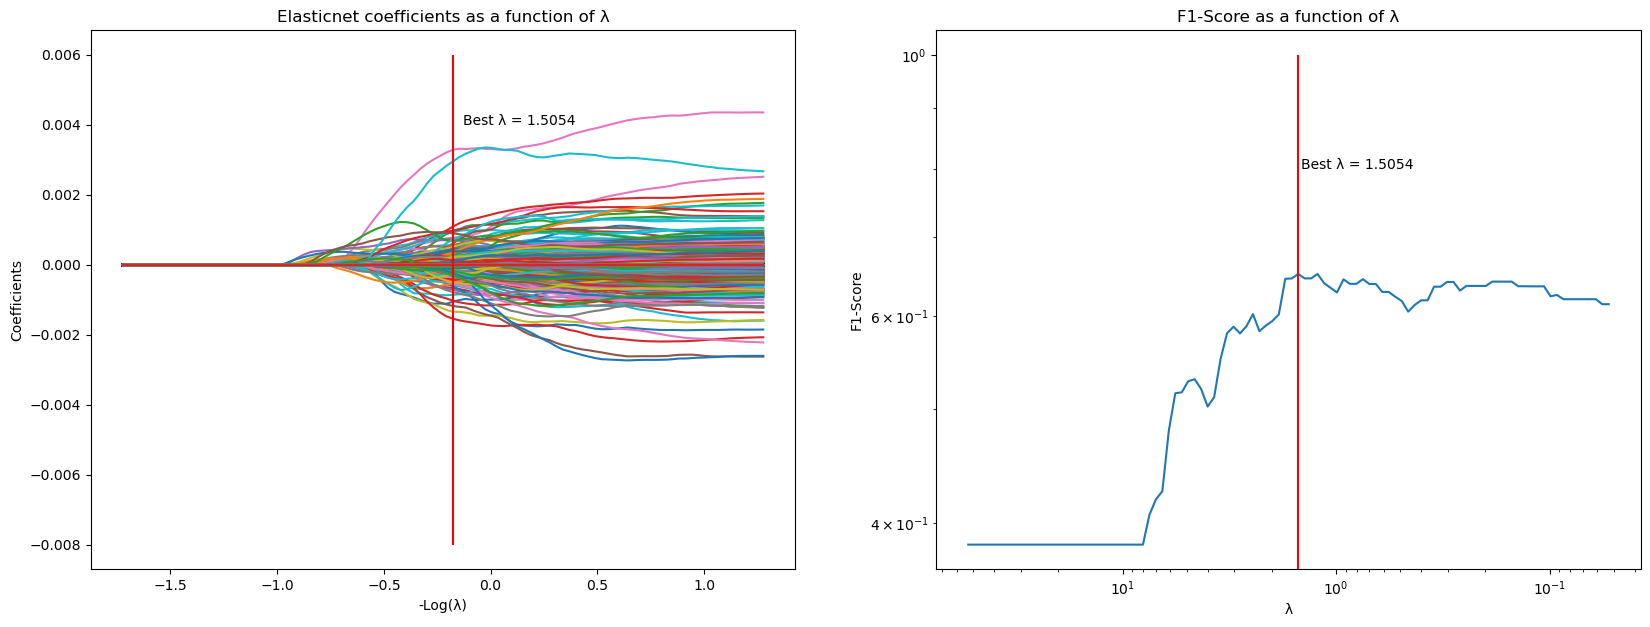

In [28]:
# Display results
best_index = np.argmax(f1_scores_mean)
print(f"Lambda with minimal f1-score: \u03BB = {np.round(lambdas_lasso[best_index], 5)}")
print(f"Respective f1-score:\tf1 = {np.round(f1_scores_mean[best_index], 3)}")

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
neg_log_lambdas_lasso = -np.log10(lambdas_lasso)

ax[0].plot(neg_log_lambdas_lasso, np.array(coefs_enet_mean))
ax[0].vlines(x=neg_log_lambdas_lasso[best_index], ymin=-0.008, ymax=0.006, color="red")
ax[0].text(neg_log_lambdas_lasso[best_index]+0.05, 0.004, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[0].set_xlabel("-Log(\u03BB)")
ax[0].set_ylabel("Coefficients")
ax[0].set_title('Elasticnet coefficients as a function of \u03BB')
ax[0].axis("tight")

ax[1].plot(lambdas_lasso, f1_scores_mean)
ax[1].vlines(x=lambdas_lasso[best_index], ymin=0, ymax=1, color="red")
ax[1].text(lambdas_lasso[best_index]-0.05, 0.8, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axis('tight')
ax[1].invert_xaxis()
ax[1].set_xlabel('\u03BB')
ax[1].set_ylabel('F1-Score')
_ = ax[1].set_title('F1-Score as a function of \u03BB')

TODO: We can try a couple more values of l1_ratio eg: 0.1 and 0.9

## Lasso and Elasticnet Comparison

(-1.8731023850278814,
 1.4268976149721184,
 -0.003116899086472358,
 0.004706762469333128)

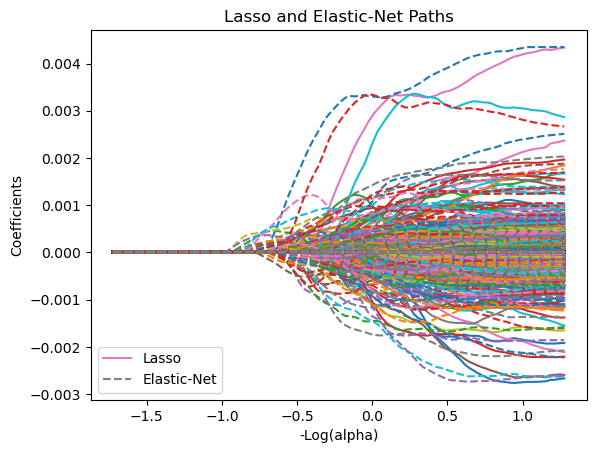

In [37]:
# Display results

plt.figure(1)
neg_log_lambdas_lasso = -np.log10(lambdas_lasso)
plt.plot(neg_log_lambdas_lasso, np.array(coefs_lasso_mean))
plt.plot(neg_log_lambdas_lasso, np.array(coefs_enet_mean), linestyle="--")

plt.xlabel("-Log(alpha)")
plt.ylabel("Coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.legend((l1[-1], l2[-1]), ("Lasso", "Elastic-Net"), loc="lower left")
plt.axis("tight")

## Logistic Model

We will compare different logistic models trained on fMRI data. We will start with a plain logistic model where we will not apply any kind of regularization. Later we will fit a lasso logistic and perform a grid search to the value of lambda that maximizes the f1-score. Later on we will do a similar experiment with a elasticnet ligistic model.

### Plain Logististic Model (without regularization)

In [38]:
f1_scores = []

for fold in range(1, 6):
    X_train, y_train, X_val, y_val = train_loader(dic, fold)
    clf = LogisticRegression(
        penalty=None,
        random_state=42,
        max_iter=7000).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    score = f1_score(y_val, y_pred, average="weighted")
    f1_scores.append(score)

    print(f"Fold {fold} -- f1-Score (val): {score}")
print(f"\nAverage f1-Score (val): {np.mean(f1_scores)}")

Fold 1 -- f1-Score (val): 0.6542857142857142
Fold 2 -- f1-Score (val): 0.6767507002801122
Fold 3 -- f1-Score (val): 0.5004329004329006
Fold 4 -- f1-Score (val): 0.5403556771545828
Fold 5 -- f1-Score (val): 0.5294117647058824

Average f1-Score (val): 0.5802473513718385


### Lasso Logistic

We are going to fit a logistic model with a lasso penalty and perform a grid search to find the value of lambda that maximizes the f1-score. We are going to test 40 different lambda values from 1e-8 to 100.

In [61]:
f1_scores_mean = []
coefs_lg_lasso_mean = []
#X_train, y_train, _, _ = train_loader(dic, 1)
#lambdas_lasso, _, _ = lasso_path(X_train, y_train, eps=eps, random_state=42) # get nicely distributed lambdas

for lam in lambdas_lasso:
    f1_scores = []
    coefs = []
    for fold in range(1, 2):

        X_train, y_train, X_val, y_val = train_loader(dic, fold)

        clf = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1/lam,
            random_state=42).fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        score = f1_score(y_val, y_pred, average="weighted")

        f1_scores.append(score)
        coefs.append(clf.coef_)

    f1_scores_mean.append(np.mean(f1_scores))
    coefs_lg_lasso_mean.append(np.mean(coefs, axis=0))

    print(f"\n Lambda = {np.round(lam, 8)}  \t\tAverage f1-Score (val): {f1_scores_mean[-1]}\n")

/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 52.85698476  		Average f1-Score (val): 0.5966666666666668



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 49.29460089  		Average f1-Score (val): 0.5966666666666668



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 45.97230977  		Average f1-Score (val): 0.5966666666666668



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 42.87392996  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 39.98437057  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 37.28955782  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 34.77636643  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 32.43255572  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 30.24671001  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 28.20818299  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 26.30704587  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 24.53403902  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 22.8805269  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 21.33845597  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 19.90031545  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 18.5591008  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 17.30827952  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 16.14175941  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 15.05385885  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 14.03927915  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 13.09307872  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 12.21064903  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 11.38769216  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 10.62019982  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 9.9044339  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 9.2369082  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 8.6143715  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 8.03379169  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 7.49234102  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 6.98738231  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 6.51645613  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 6.0772688  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 5.66768122  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 5.28569848  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 4.92946009  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 4.59723098  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 4.287393  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.99843706  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.72895578  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.47763664  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.24325557  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.024671  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.8208183  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.63070459  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.4534039  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.28805269  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.1338456  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.99003155  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.85591008  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.73082795  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.61417594  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.50538588  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.40392791  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.30930787  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.2210649  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.13876922  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.06201998  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.99044339  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.92369082  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.86143715  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.80337917  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.7492341  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.69873823  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.65164561  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.60772688  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.56676812  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.52856985  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.49294601  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.4597231  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.4287393  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.39984371  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.37289558  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.34776366  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.32432556  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.3024671  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.28208183  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.26307046  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.24534039  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.22880527  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.21338456  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.19900315  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.18559101  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.1730828  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.16141759  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.15053859  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.14039279  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.13093079  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.12210649  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.11387692  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.106202  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.09904434  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.09236908  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.08614372  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.08033792  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.07492341  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.06987382  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.06516456  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.06077269  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.05667681  		Average f1-Score (val): 0.627342549923195


 Lambda = 0.05285698  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lambda with minimal f1-score: λ = 30.24671
Respective f1-score:	f1 = 0.657


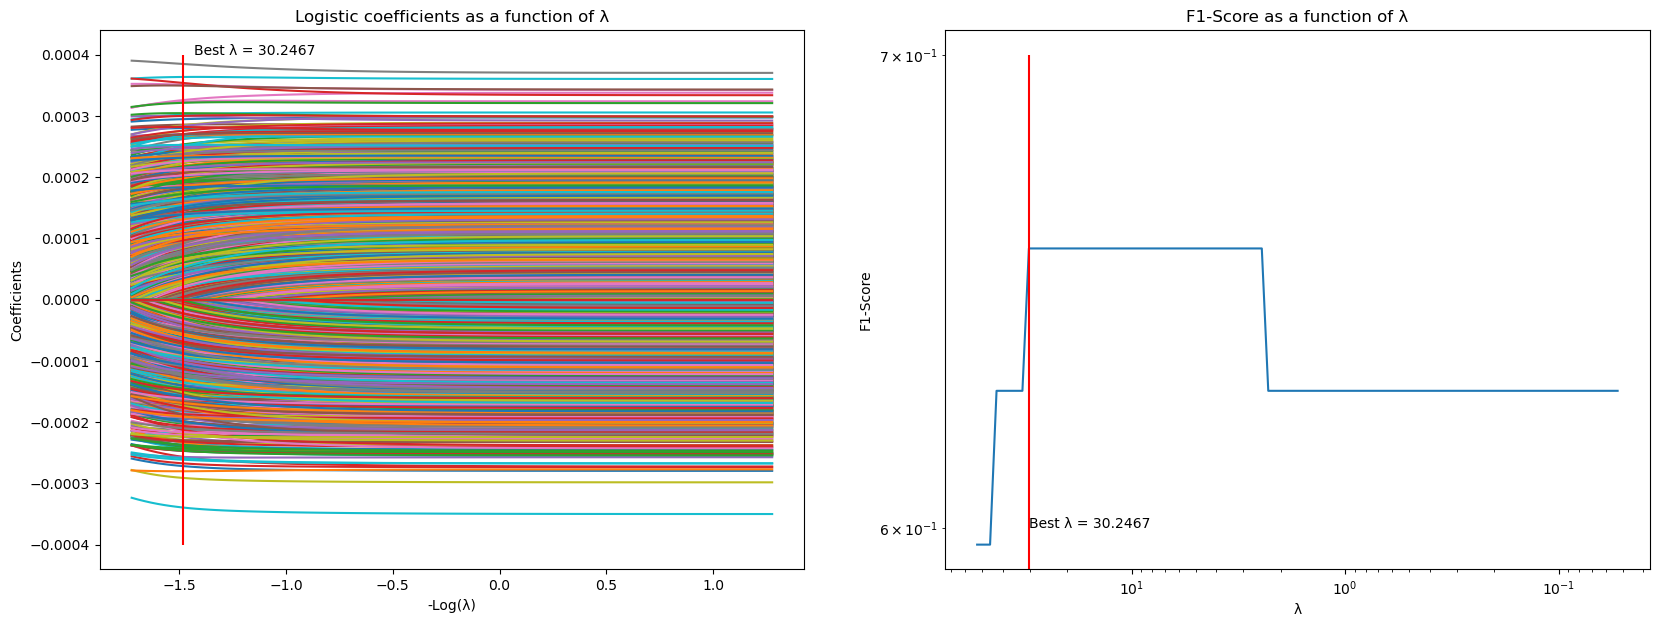

In [64]:
# Display results
best_index = np.argmax(f1_scores_mean)
print(f"Lambda with minimal f1-score: \u03BB = {np.round(lambdas_lasso[best_index], 5)}")
print(f"Respective f1-score:\tf1 = {np.round(f1_scores_mean[best_index], 3)}")

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
neg_log_lambdas_lasso = -np.log10(lambdas_lasso)

ax[0].plot(neg_log_lambdas_lasso, np.array(coefs_lg_lasso_mean)[:,0,:])
ax[0].vlines(x=neg_log_lambdas_lasso[best_index], ymin=-0.0004, ymax=0.0004, color="red")
ax[0].text(neg_log_lambdas_lasso[best_index]+0.05, 0.0004, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[0].set_xlabel("-Log(\u03BB)")
ax[0].set_ylabel("Coefficients")
ax[0].set_title('Logistic coefficients as a function of \u03BB')
ax[0].axis("tight")

ax[1].plot(lambdas_lasso, f1_scores_mean)
ax[1].vlines(x=lambdas_lasso[best_index], ymin=0, ymax=0.7, color="red")
ax[1].text(lambdas_lasso[best_index]-0.05, 0.6, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axis('tight')
ax[1].invert_xaxis()
ax[1].set_xlabel('\u03BB')
ax[1].set_ylabel('F1-Score')
_ = ax[1].set_title('F1-Score as a function of \u03BB')

### Elasticnet Logistic

In this case we are going to apply a elasticnet regularization to the logistic model. Meaning we are going to perform a mix between lasso and ridge regularization. In this occasion we are going to test 10 different values of lambda and 3 different values of l1_ratio 0.1, 0.5 and, 0.9. 

Setting l1_ratio=0 is equivalent to using a ridge penalty, while setting l1_ratio=1 is equivalent to using a lasso penalty. For 0 < l1_ratio <1, the penalty is a combination of lasso and ridge.

In [65]:
f1_scores_mean = []
coefs_lg_enet_mean = []
#X_train, y_train, _, _ = train_loader(dic, 1)
#lambdas_lasso, _, _ = lasso_path(X_train, y_train, eps=eps, random_state=42) # get nicely distributed lambdas

for lam in lambdas_lasso:
    f1_scores = []
    coefs = []
    for fold in range(1, 2):

        X_train, y_train, X_val, y_val = train_loader(dic, fold)

        clf = LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            C=1/lam,
            l1_ratio=0.5,
            random_state=42).fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        score = f1_score(y_val, y_pred, average="weighted")

        f1_scores.append(score)
        coefs.append(clf.coef_)

    f1_scores_mean.append(np.mean(f1_scores))
    coefs_lg_enet_mean.append(np.mean(coefs, axis=0))

    print(f"\n Lambda = {np.round(lam, 8)}  \t\tAverage f1-Score (val): {f1_scores_mean[-1]}\n")

/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 52.85698476  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 49.29460089  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 45.97230977  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 42.87392996  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 39.98437057  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 37.28955782  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 34.77636643  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 32.43255572  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 30.24671001  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 28.20818299  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 26.30704587  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 24.53403902  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 22.8805269  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 21.33845597  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 19.90031545  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 18.5591008  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 17.30827952  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 16.14175941  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 15.05385885  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 14.03927915  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 13.09307872  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 12.21064903  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 11.38769216  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 10.62019982  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 9.9044339  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 9.2369082  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 8.6143715  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 8.03379169  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 7.49234102  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 6.98738231  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 6.51645613  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 6.0772688  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 5.66768122  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 5.28569848  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 4.92946009  		Average f1-Score (val): 0.6571428571428571



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 4.59723098  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 4.287393  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.99843706  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.72895578  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.47763664  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.24325557  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 3.024671  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.8208183  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.63070459  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.4534039  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.28805269  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 2.1338456  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.99003155  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.85591008  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.73082795  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.61417594  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.50538588  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.40392791  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.30930787  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.2210649  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.13876922  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 1.06201998  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.99044339  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.92369082  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.86143715  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.80337917  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.7492341  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.69873823  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.65164561  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.60772688  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.56676812  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.52856985  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.49294601  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.4597231  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.4287393  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.39984371  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.37289558  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.34776366  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.32432556  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.3024671  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.28208183  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.26307046  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.24534039  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.22880527  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.21338456  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.19900315  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.18559101  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.1730828  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.16141759  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.15053859  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.14039279  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.13093079  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.12210649  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.11387692  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.106202  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.09904434  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.09236908  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.08614372  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.08033792  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.07492341  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.06987382  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.06516456  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.06077269  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 Lambda = 0.05667681  		Average f1-Score (val): 0.627342549923195


 Lambda = 0.05285698  		Average f1-Score (val): 0.627342549923195



/Users/santiago/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lambda with minimal f1-score: λ = 52.85698
Respective f1-score:	f1 = 0.657


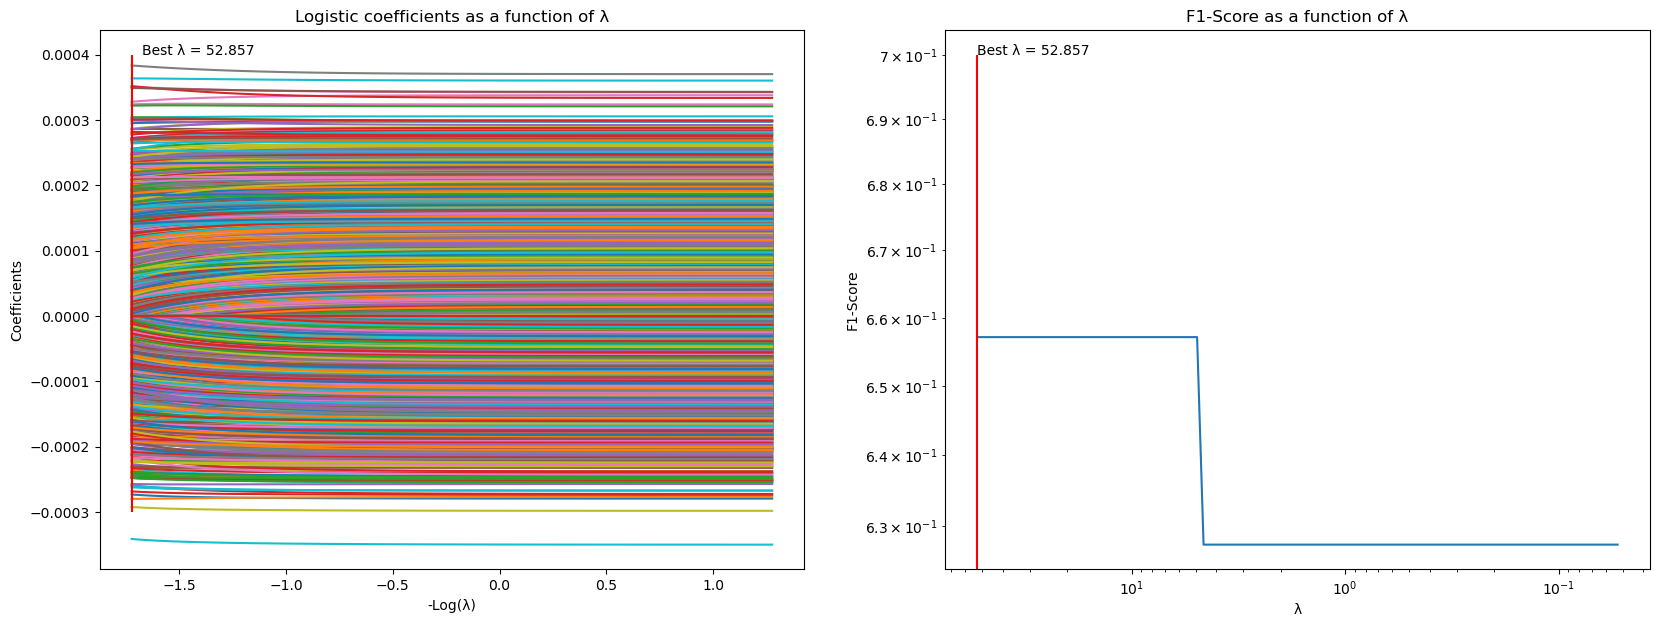

In [67]:
# Display results
best_index = np.argmax(f1_scores_mean)
print(f"Lambda with minimal f1-score: \u03BB = {np.round(lambdas_lasso[best_index], 5)}")
print(f"Respective f1-score:\tf1 = {np.round(f1_scores_mean[best_index], 3)}")

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
neg_log_lambdas_lasso = -np.log10(lambdas_lasso)

ax[0].plot(neg_log_lambdas_lasso, np.array(coefs_lg_enet_mean)[:,0,:])
ax[0].vlines(x=neg_log_lambdas_lasso[best_index], ymin=-0.0003, ymax=0.0004, color="red")
ax[0].text(neg_log_lambdas_lasso[best_index]+0.05, 0.0004, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[0].set_xlabel("-Log(\u03BB)")
ax[0].set_ylabel("Coefficients")
ax[0].set_title('Logistic coefficients as a function of \u03BB')
ax[0].axis("tight")

ax[1].plot(lambdas_lasso, f1_scores_mean)
ax[1].vlines(x=lambdas_lasso[best_index], ymin=0, ymax=0.7, color="red")
ax[1].text(lambdas_lasso[best_index]-0.05, 0.7, f"Best \u03BB = {np.round(lambdas_lasso[best_index], 4)}")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axis('tight')
ax[1].invert_xaxis()
ax[1].set_xlabel('\u03BB')
ax[1].set_ylabel('F1-Score')
_ = ax[1].set_title('F1-Score as a function of \u03BB')

TODO: Increase the range of lambda values for both the lasso and elasticnet logistic models.

TODO: Perform SVM Lasso